In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multinomial
from typing import List
from scipy.stats import norm
import theano.tensor as tt
import theano


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In this notebook we extend the application of HMMs to Markov Decision Process (MDP) and Partially Observable Markov Decision Process (POMDP). In an MDP, the agent observes the true state, it takes an action according to this state, and the system moves to the next state according to the transition model which is conditioned on both states and actions. The graphical model is:

<img src="images/mdp.png">

Unlike the previous work, we thus have a transition probability matrix for each possible action (we consider discrete states and actions).

In a POMDP, the true states are not observables (hidden variables), but the agent observes the emissions of the system according to the observation model. The graphical model becomes:

<img src="images/pomdp.png">

The focus of the notebook is once again the recovery of the transition model via HMM. Consequently, it is not necessary to consider the rewards associated with the chosen actions, which usually characterize the MDP and POMDP.

## Data Generating Process

This section shows the data generating process of MDP and POMDP we will consider throughout the notebook.

The Markov Chain is still described by a number of possible states, an initial probability distribution and the transition model. In addition, we also have a number of possible actions and the transition model includes one matrix per available action. We simulate the actions by assigning them different probabilities.

In [2]:
n_states = 3
n_actions = 2

p_init = np.array([1/3., 1/3., 1/3.])
p_actions = np.array([0.9, 0.1])
p_transition_0 = np.array(
    [[0.90, 0.09, 0.01],
     [0.01, 0.90, 0.09],
     [0.01, 0.05, 0.94]]
)
p_transition_1 = np.array(
    [[1.  , 0.  , 0.  ],
     [0.9 , 0.1 , 0.  ],
     [0.49, 0.5 , 0.01]]
)
p_transitions = np.array([p_transition_0, p_transition_1])
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

In [3]:
for i in range(n_actions):
    assert p_transitions[i, 0, :].sum() == 1
    assert p_transitions[i, 1, :].sum() == 1
    assert p_transitions[i, 2, :].sum() == 1

In [4]:
def mdp_sequence(p_init: np.array, p_actions:np.array, p_transitions: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov Decision Process sequence based on p_init, p_actions and p_transitions.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    initial_action = list(multinomial.rvs(1, p_actions)).index(1)

    states = [initial_state]
    actions = [initial_action]
    for _ in range(sequence_length - 1):
        p_tr = p_transitions[actions[-1], states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        new_action = list(multinomial.rvs(1, p_actions)).index(1)
        states.append(new_state)
        actions.append(new_action)
    return states, actions

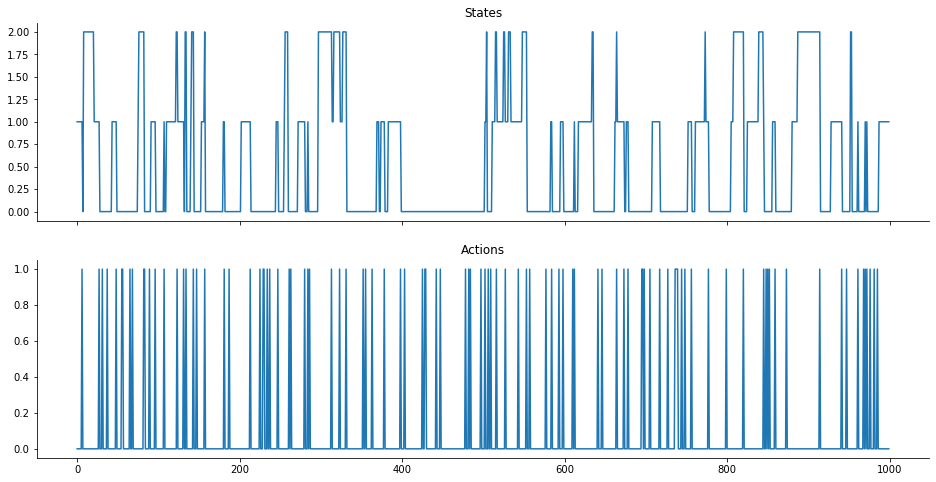

In [5]:
lenght_seq = 1000

states, actions = mdp_sequence(p_init, p_actions, p_transitions, sequence_length=lenght_seq)
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
ax[0].plot(states)
ax[0].set_title("States")
ax[1].plot(actions)
ax[1].set_title("Actions")
sns.despine();

We then simulate the observations in the POMDP case according to an autoregressive and heteroskedatic Gaussian model, which is a rather complex (because of the conditioning on previous observations) but also general observation model.

In [6]:
def ar_gaussian_heteroskedastic_emissions(states: List[int], k: float, mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=k * prev_loc + mus[state], scale=sigmas[state])
        emissions.append(e)
        prev_loc = e
    return emissions


def plot_emissions(states, emissions, actions):
    fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=1, sharex=True)
    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    axes[2].plot(actions)
    axes[2].set_title("Actions")
    sns.despine();

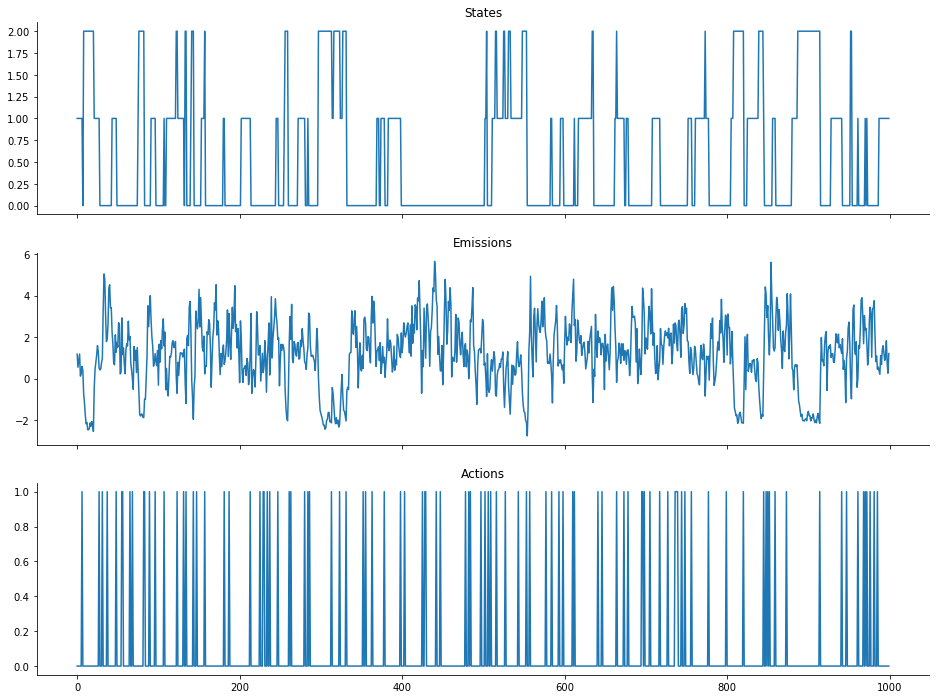

In [7]:
k = 0.5
mus = [1, 0.5, -1]
sigmas = [1, 0.5, 0.2]

ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k, mus, sigmas)
plot_emissions(states, ar_het_ems, actions)

## HMM 

The HMM is implemented below. We estimate both the initial probability distribution and the transition probability matrices conditioned on the actions.

In [8]:
class HMMStates(pm.Categorical):
    def __init__(self, p_transition, init_prob, actions, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.init_prob = init_prob
        self.actions = actions
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_init = self.init_prob
        acts = self.actions[:-1]
        p_tr = self.p_transition[acts, x[:-1]]

        # the logp of the initial state 
        initial_state_logp = pm.Categorical.dist(p_init).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

## MDP

We first recover the transition model for the MDP case. It should be noted the further dimension n_actions in the transition_mat variable.

In [9]:
with pm.Model() as model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), 
        shape=(n_actions, n_states, n_states))

    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    obs_states = HMMStates(
        "states",
        p_transition=transition_mat,
        init_prob=init_probs,
        n_states=n_states,
        actions = actions,
        observed=np.array(states).astype("float")
    )
    
    trace = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, p_transition]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


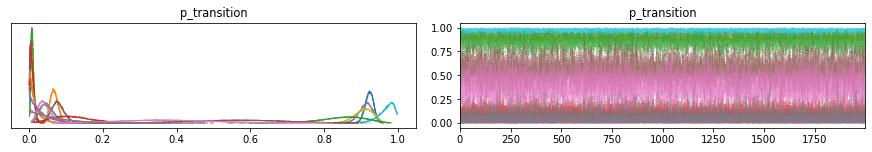

In [10]:
az.plot_trace(trace,  var_names=["p_transition"]);

The true matrices are:

In [11]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

And the HMM estimated:

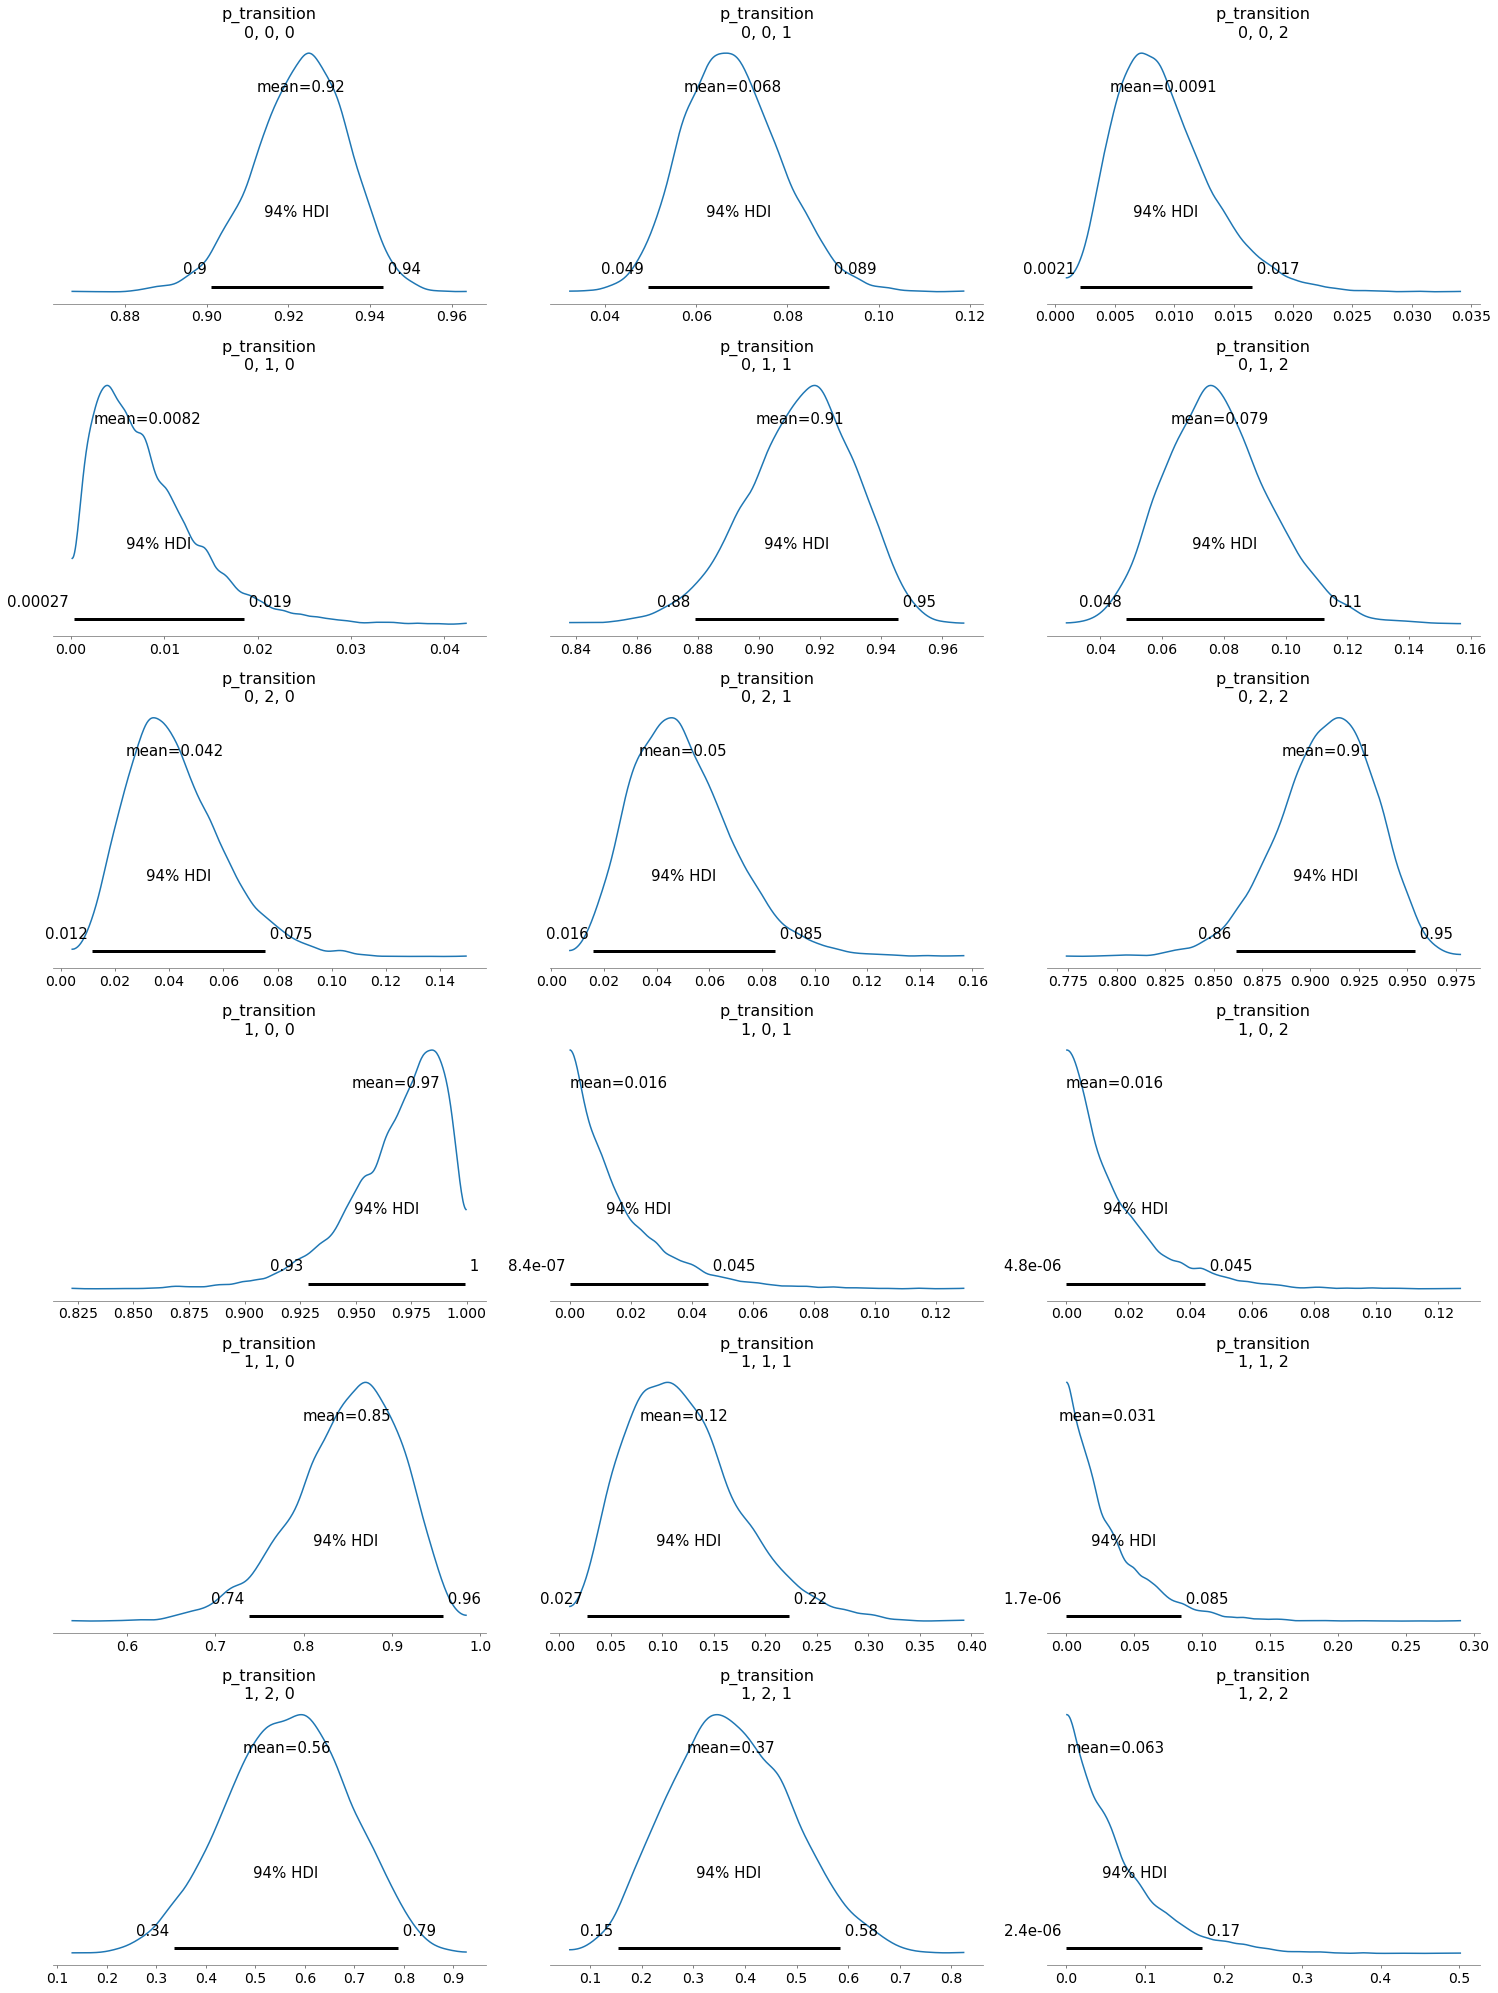

In [12]:
az.plot_posterior(trace, var_names=["p_transition"]);

The inference results are very good.

## POMDP with  ARHMM Gaussian Emissions

We now move to the case of POMDP with Gaussian emissions generated by the hidden states. Below the observation model is implemented. 

In [14]:
class ARHMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, k, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma 
        self.mu = mu
        self.k = k

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]
        k = self.k

        ar_mean = k * x[:-1]
        ar_like = tt.sum(pm.Normal.dist(mu=ar_mean + mu[1:], sigma=sigma[1:]).logp(x[1:])) 

        boundary_like = pm.Normal.dist(mu=mu[0], sigma=sigma[0]).logp(x[0])
        return ar_like + boundary_like

When estimating the model, rather than assigning the usual prior $\mu \sim \mathcal{N}(0,1)$, we give different priors to $\mu$ in order to avoid intra-chain omogeneity (non-identifiability). The model is hence summarized as follows:

\begin{equation}
\mathcal{S} = \{0, 1, 2\}
\end{equation}

\begin{equation}
s_t \in \mathcal{S}
\end{equation}

\begin{equation}
s_t | s_{t-1}, a_{t-1} \sim Dirichlet(\alpha)
\end{equation}

\begin{equation}
\mu_{s_t} \sim \mathcal{N}(\bar{\mu}_i, 1)
\end{equation}

\begin{equation}
\bar{\mu}_i = \{0.5, 0, -0.5\}, i \in \mathcal{S}
\end{equation}

\begin{equation}
\sigma_{s_t} \sim Exp(2) \hspace{0.2cm} \forall i \in \mathcal{S}
\end{equation}

\begin{equation}
k \sim Beta(2,2)
\end{equation}

\begin{equation}
y_t | s_t \sim \mathcal{N}(ky_{t-1} + \mu_{s_t}, \sigma_{s_t})
\end{equation}


In [15]:
with pm.Model() as model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), 
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=transition_mat,
        init_prob=init_probs,
        n_states=n_states,
        actions = actions,
        shape=(len(ar_het_ems),)
    )

    # Prior for mu, sigma and k
    μ = pm.Normal("mu", mu=[0.5, 0., -0.5], sigma=1, shape=(n_states,)) # different priors for the 3 Normal dist
    σ = pm.Exponential("sigma", lam=2, shape=(n_states,))
    k_p = pm.Beta("k", alpha=2, beta=2) 

    # Observed emission likelihood
    obs = ARHMMGaussianEmissions(
        "emission",
        states=hmm_states,
        mu=μ,
        sigma=σ,
        k=k_p,
        observed=ar_het_ems
    )
    
    nuts_step = pm.NUTS([model.k, model.sigma, model.mu, model.p_transition, model.init_probs], target_accept=0.9)  
    trace = pm.sample(2000, step=[nuts_step])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, p_transition, mu, sigma, k]
>CategoricalGibbsMetropolis: [hmm_states]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1808 seconds.
/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


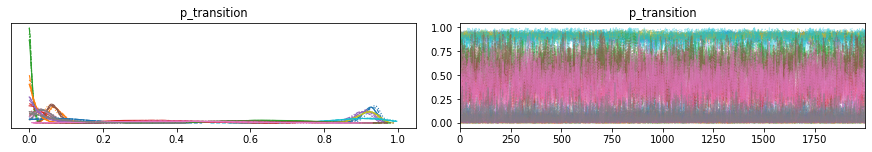

In [16]:
az.plot_trace(trace, var_names=["p_transition"]);

In [17]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

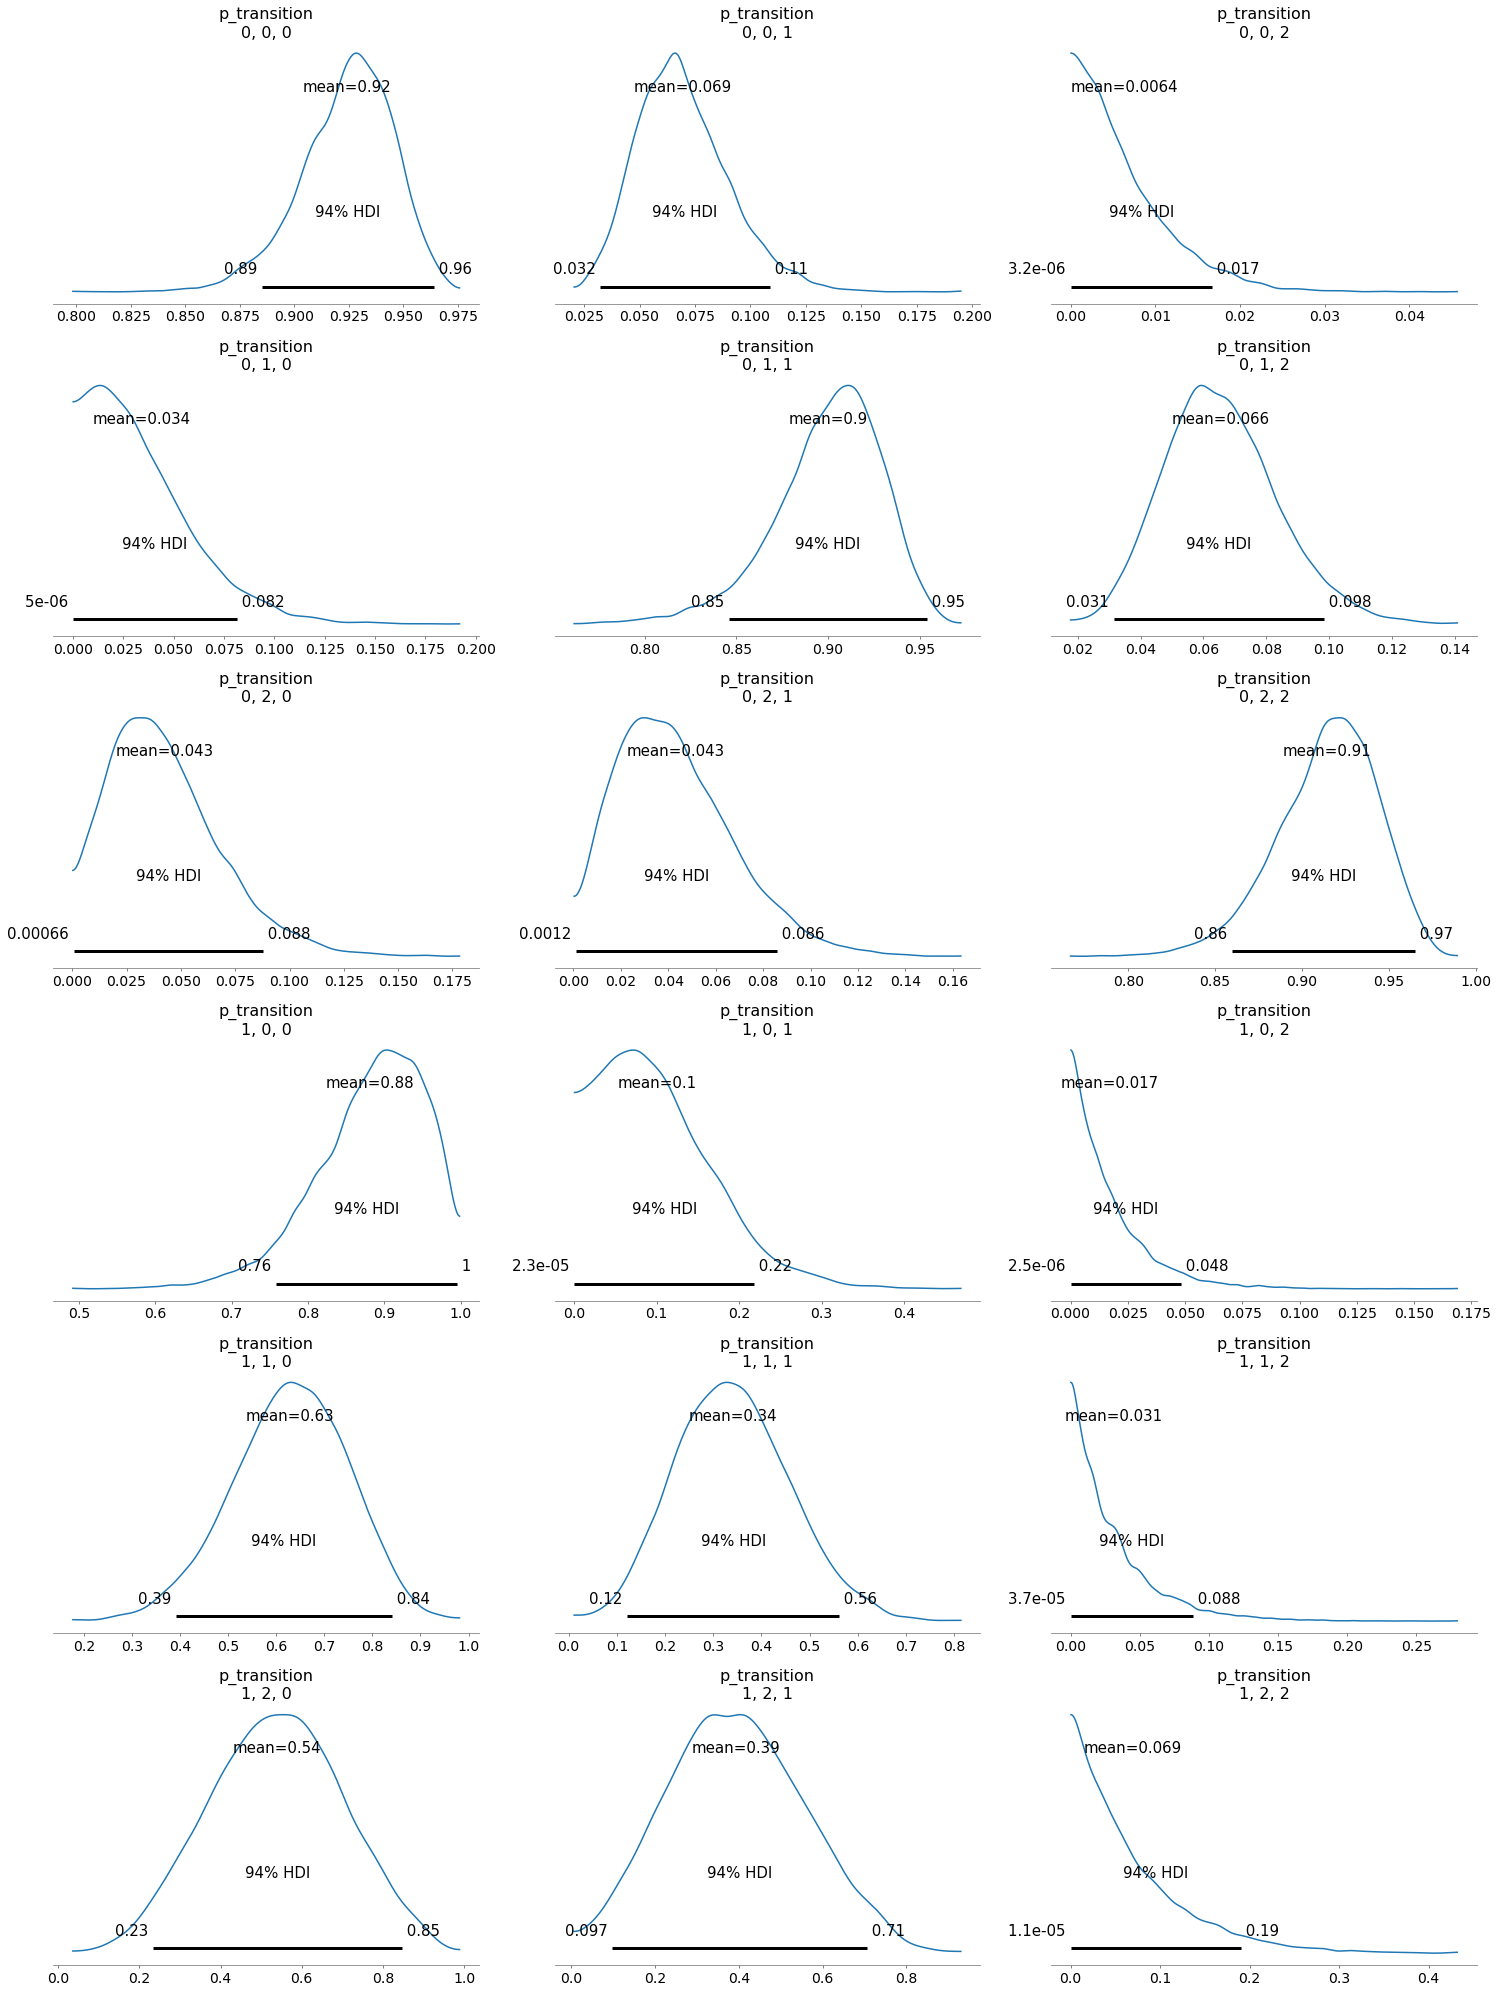

In [18]:
az.plot_posterior(trace, var_names=["p_transition"]);

Despite the lower accuracy, the inference results still look satisfactory. The other model parameters as well as the hidden states are estimated very well, as shown below. 

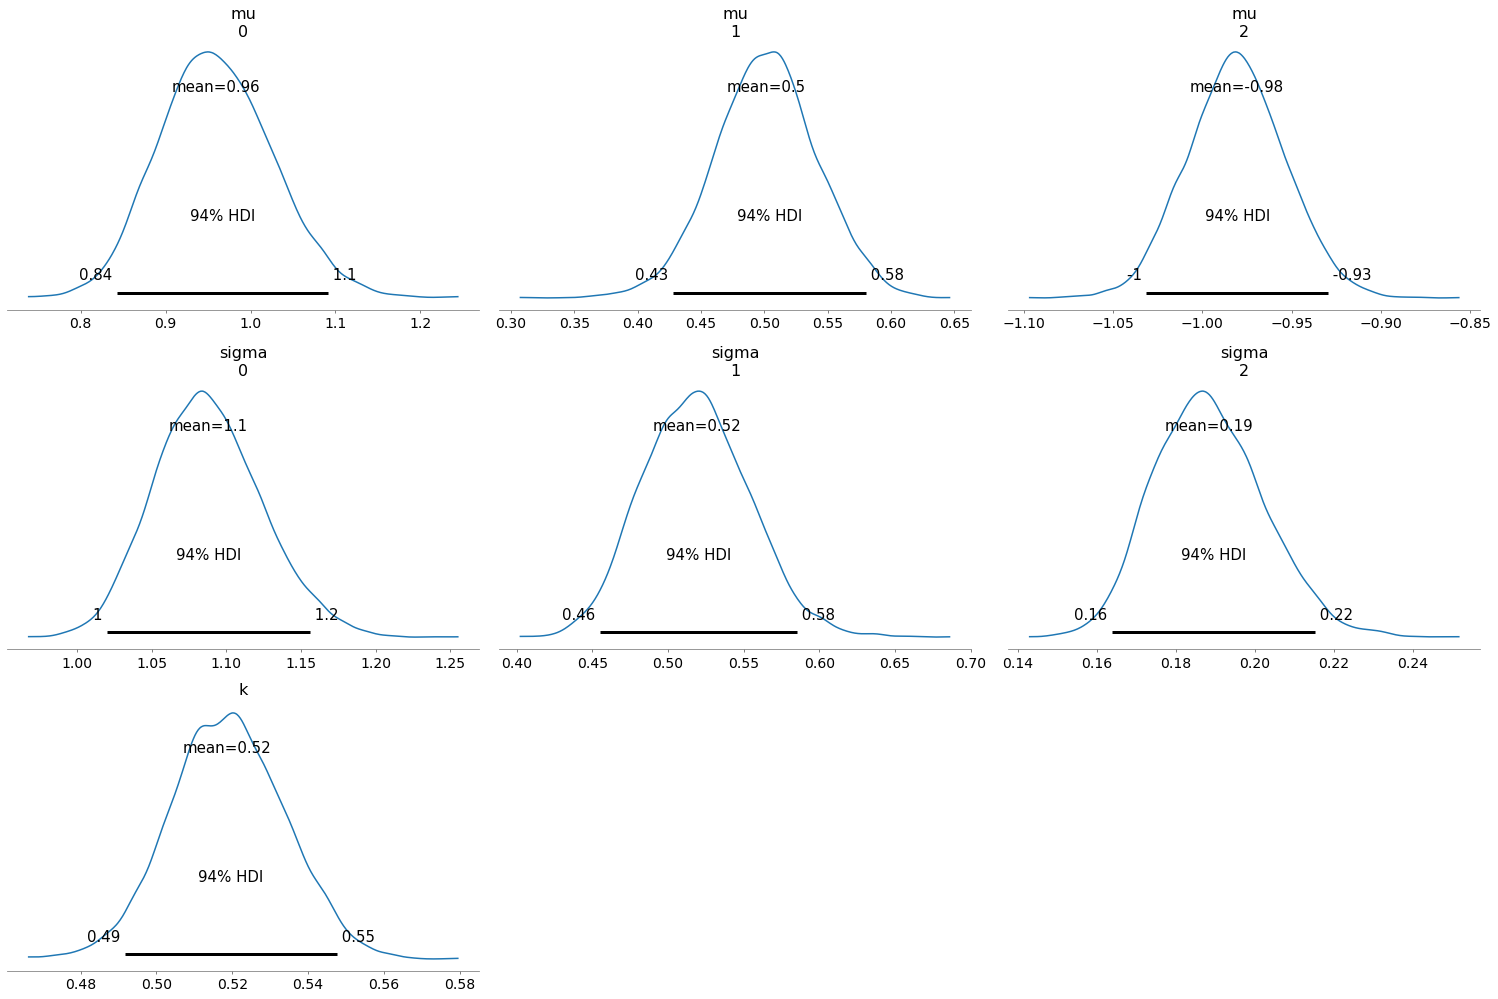

In [20]:
az.plot_posterior(trace, var_names=["mu", "sigma", "k"]);

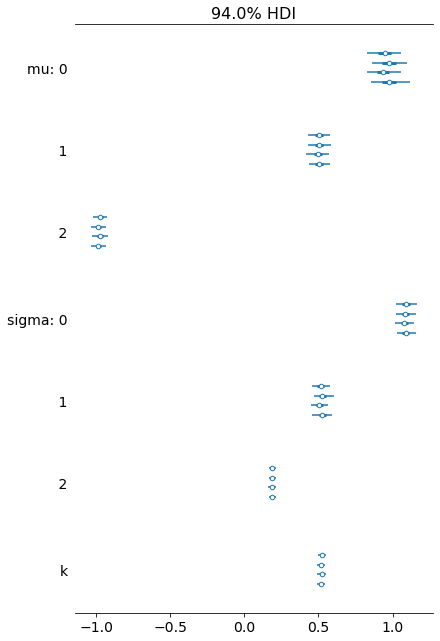

In [21]:
az.plot_forest(trace, var_names=["mu", "sigma", "k"]);

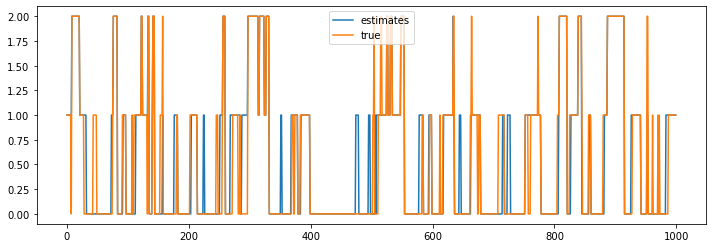

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(np.round(trace["hmm_states"].mean(axis=0)), label="estimates")
plt.plot(np.array(states), label="true")
plt.legend();

## Multiple Sequence

When dealing with real data, it is likely to have multiple (short) sequences rather than one longer. In this section we show which changes are needed to handle multiple sequences.

In [24]:
def generate_multiple_mdp_seq(lenght_seq, number_seq, p_transition, p_init, p_actions, k, mus, sigmas, plot=True): 
    #Generating a Markov Sequence
    states_all_seq = np.full((number_seq, lenght_seq), np.nan)
    actions_all_seq = np.full((number_seq, lenght_seq), np.nan)
    for i in range(number_seq):
        states, actions = mdp_sequence(p_init, p_actions, p_transitions, sequence_length=lenght_seq)
        states_all_seq[i, :] = states
        actions_all_seq[i, :] = actions
    states_all_seq = states_all_seq.astype(int)
    actions_all_seq = actions_all_seq.astype(int)
    # Generate Emissions: states and observables
    emissions_all_seq = np.full((number_seq, lenght_seq), np.nan)
    for i in range(number_seq):
        emissions = ar_gaussian_heteroskedastic_emissions(states_all_seq[i, :], k, mus, sigmas)
        emissions_all_seq[i, :] = emissions
        if plot:
            plot_emissions(states_all_seq[i, :], emissions_all_seq[i, :], actions_all_seq[i, :])
    
    return states_all_seq, emissions_all_seq, actions_all_seq

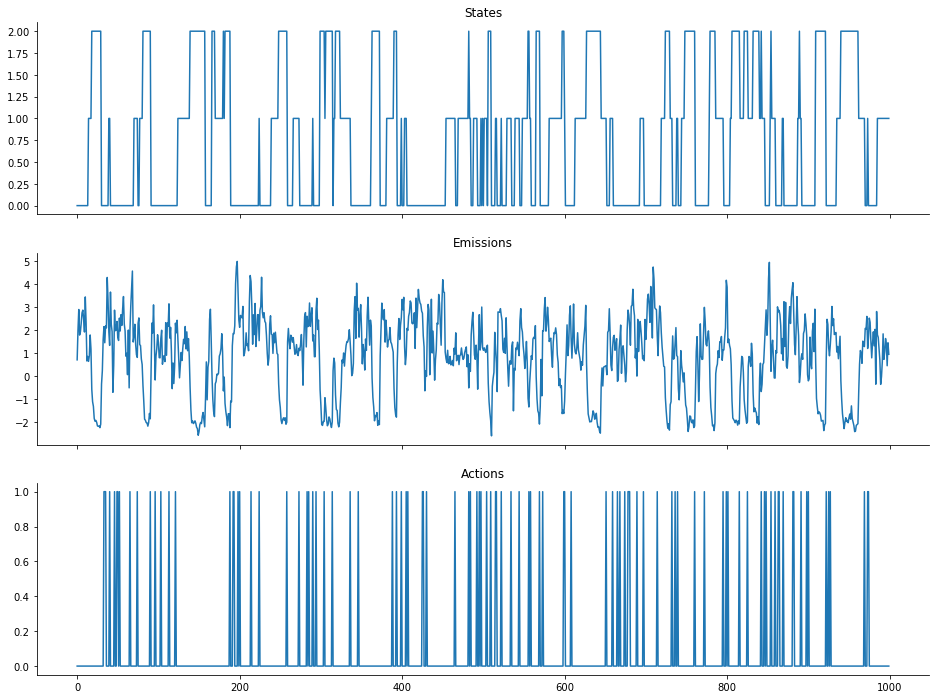

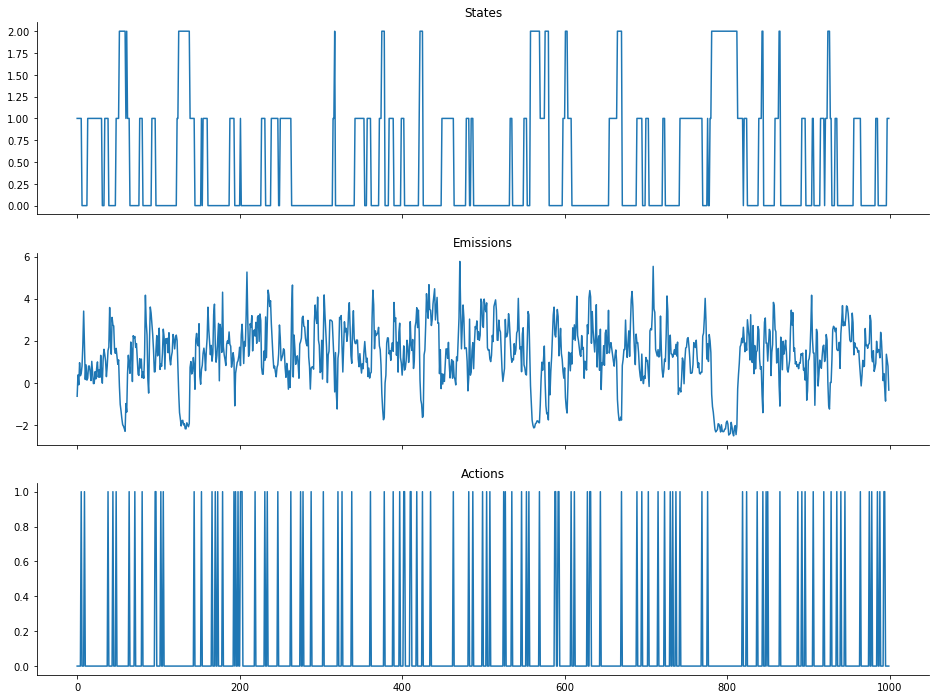

In [25]:
lenght_seq = 1000
number_seq = 2
k = 0.5
mus = [1, 0.5, -1]
sigmas = [1, 0.5, 0.2]

states_all_seq, emissions_all_seq, actions_all_seq = generate_multiple_mdp_seq(lenght_seq, number_seq, p_transitions, p_init, p_actions, k, mus, sigmas)

### MDP

First, the case of fully observable states is presented.

In [26]:
with pm.Model() as model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), 
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    for i in range(number_seq):
        obs_states = HMMStates(
            "states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            observed=np.array(states_all_seq[i, :]).astype("float")
        )
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, p_transition]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 83 seconds.


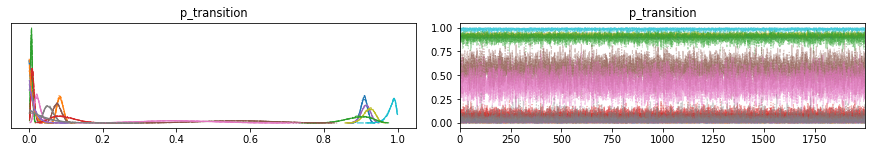

In [27]:
az.plot_trace(trace,  var_names=["p_transition"]);

In [28]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

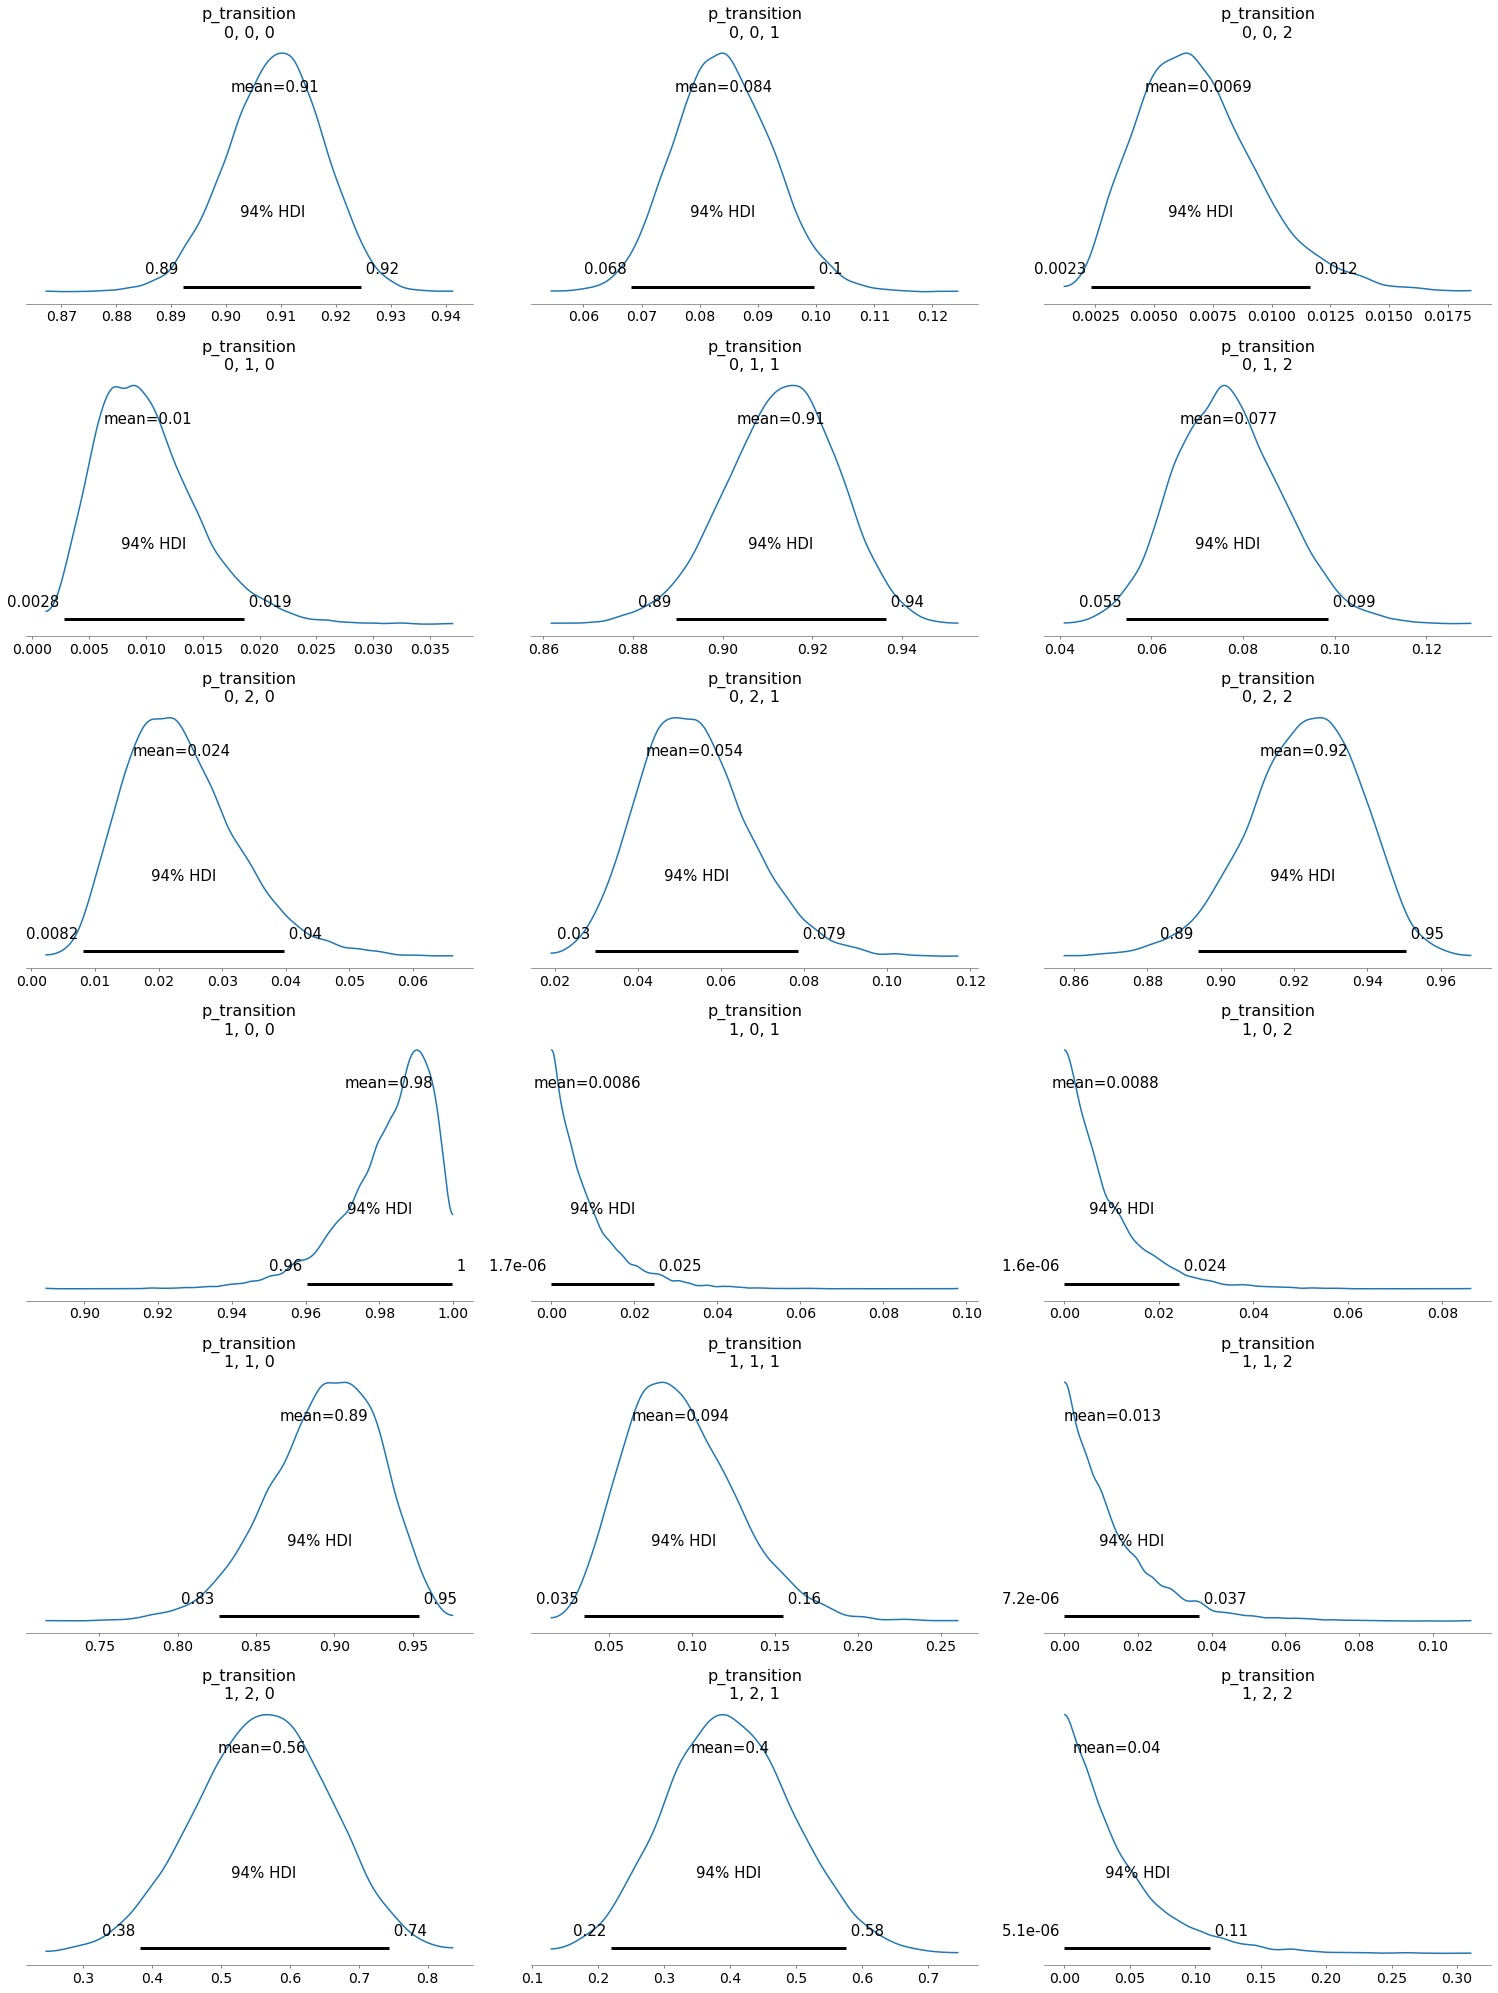

In [29]:
az.plot_posterior(trace,  var_names=["p_transition"]);

The MCMC sampling worked well with multiple sequences and the tranisition probability matrices are perfectly inferred in the MDP case.

### POMDP

We now present the case with hidden states and autoregressive Gaussian emissions.

In [30]:
with pm.Model() as model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), 
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    # Prior for mu, sigma and k
    μ = pm.Normal("mu", mu=[0.5, 0., -0.5], sigma=1, shape=(n_states,)) 
    σ = pm.Exponential("sigma", lam=2, shape=(n_states,))
    k_p = pm.Beta("k", alpha=2, beta=2) 
    
    for i in range(number_seq):
        # HMM state
        hmm_states_i = HMMStates(
            "hmm_states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            shape=(lenght_seq,)
        )


        # Observed emission likelihood
        obs_i = ARHMMGaussianEmissions(
            "emission_i" + str(i),
            states=hmm_states_i,
            mu=μ,
            sigma=σ,
            k=k_p,
            observed=np.array(emissions_all_seq[i, :]).astype("float")
        )
        
    nuts_step = pm.NUTS([model.k, model.sigma, model.mu, model.p_transition, model.init_probs], target_accept=0.9) 
    trace = pm.sample(2000, step=[nuts_step])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, p_transition, mu, sigma, k]
>CategoricalGibbsMetropolis: [hmm_states_1, hmm_states_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5154 seconds.
/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


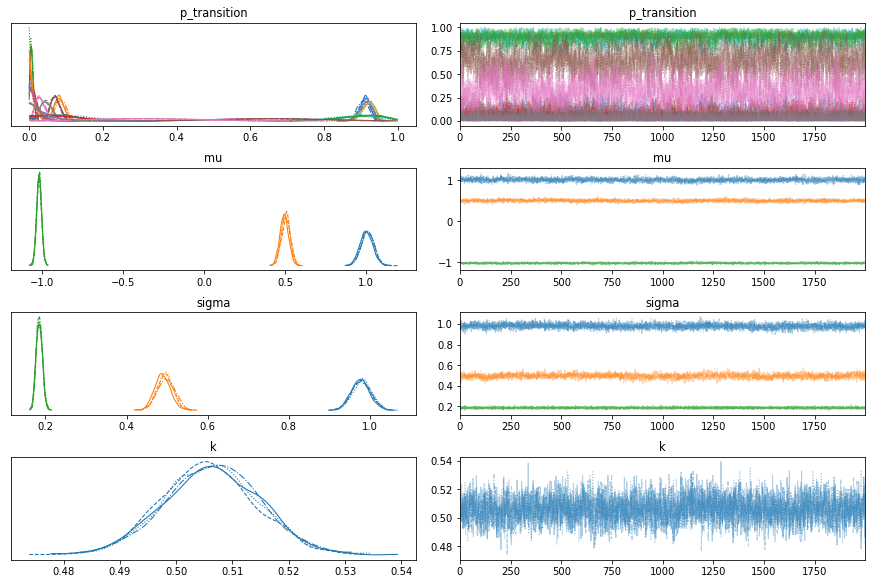

In [31]:
az.plot_trace(trace,  var_names=["p_transition", "mu", "sigma", "k"]);

In [32]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

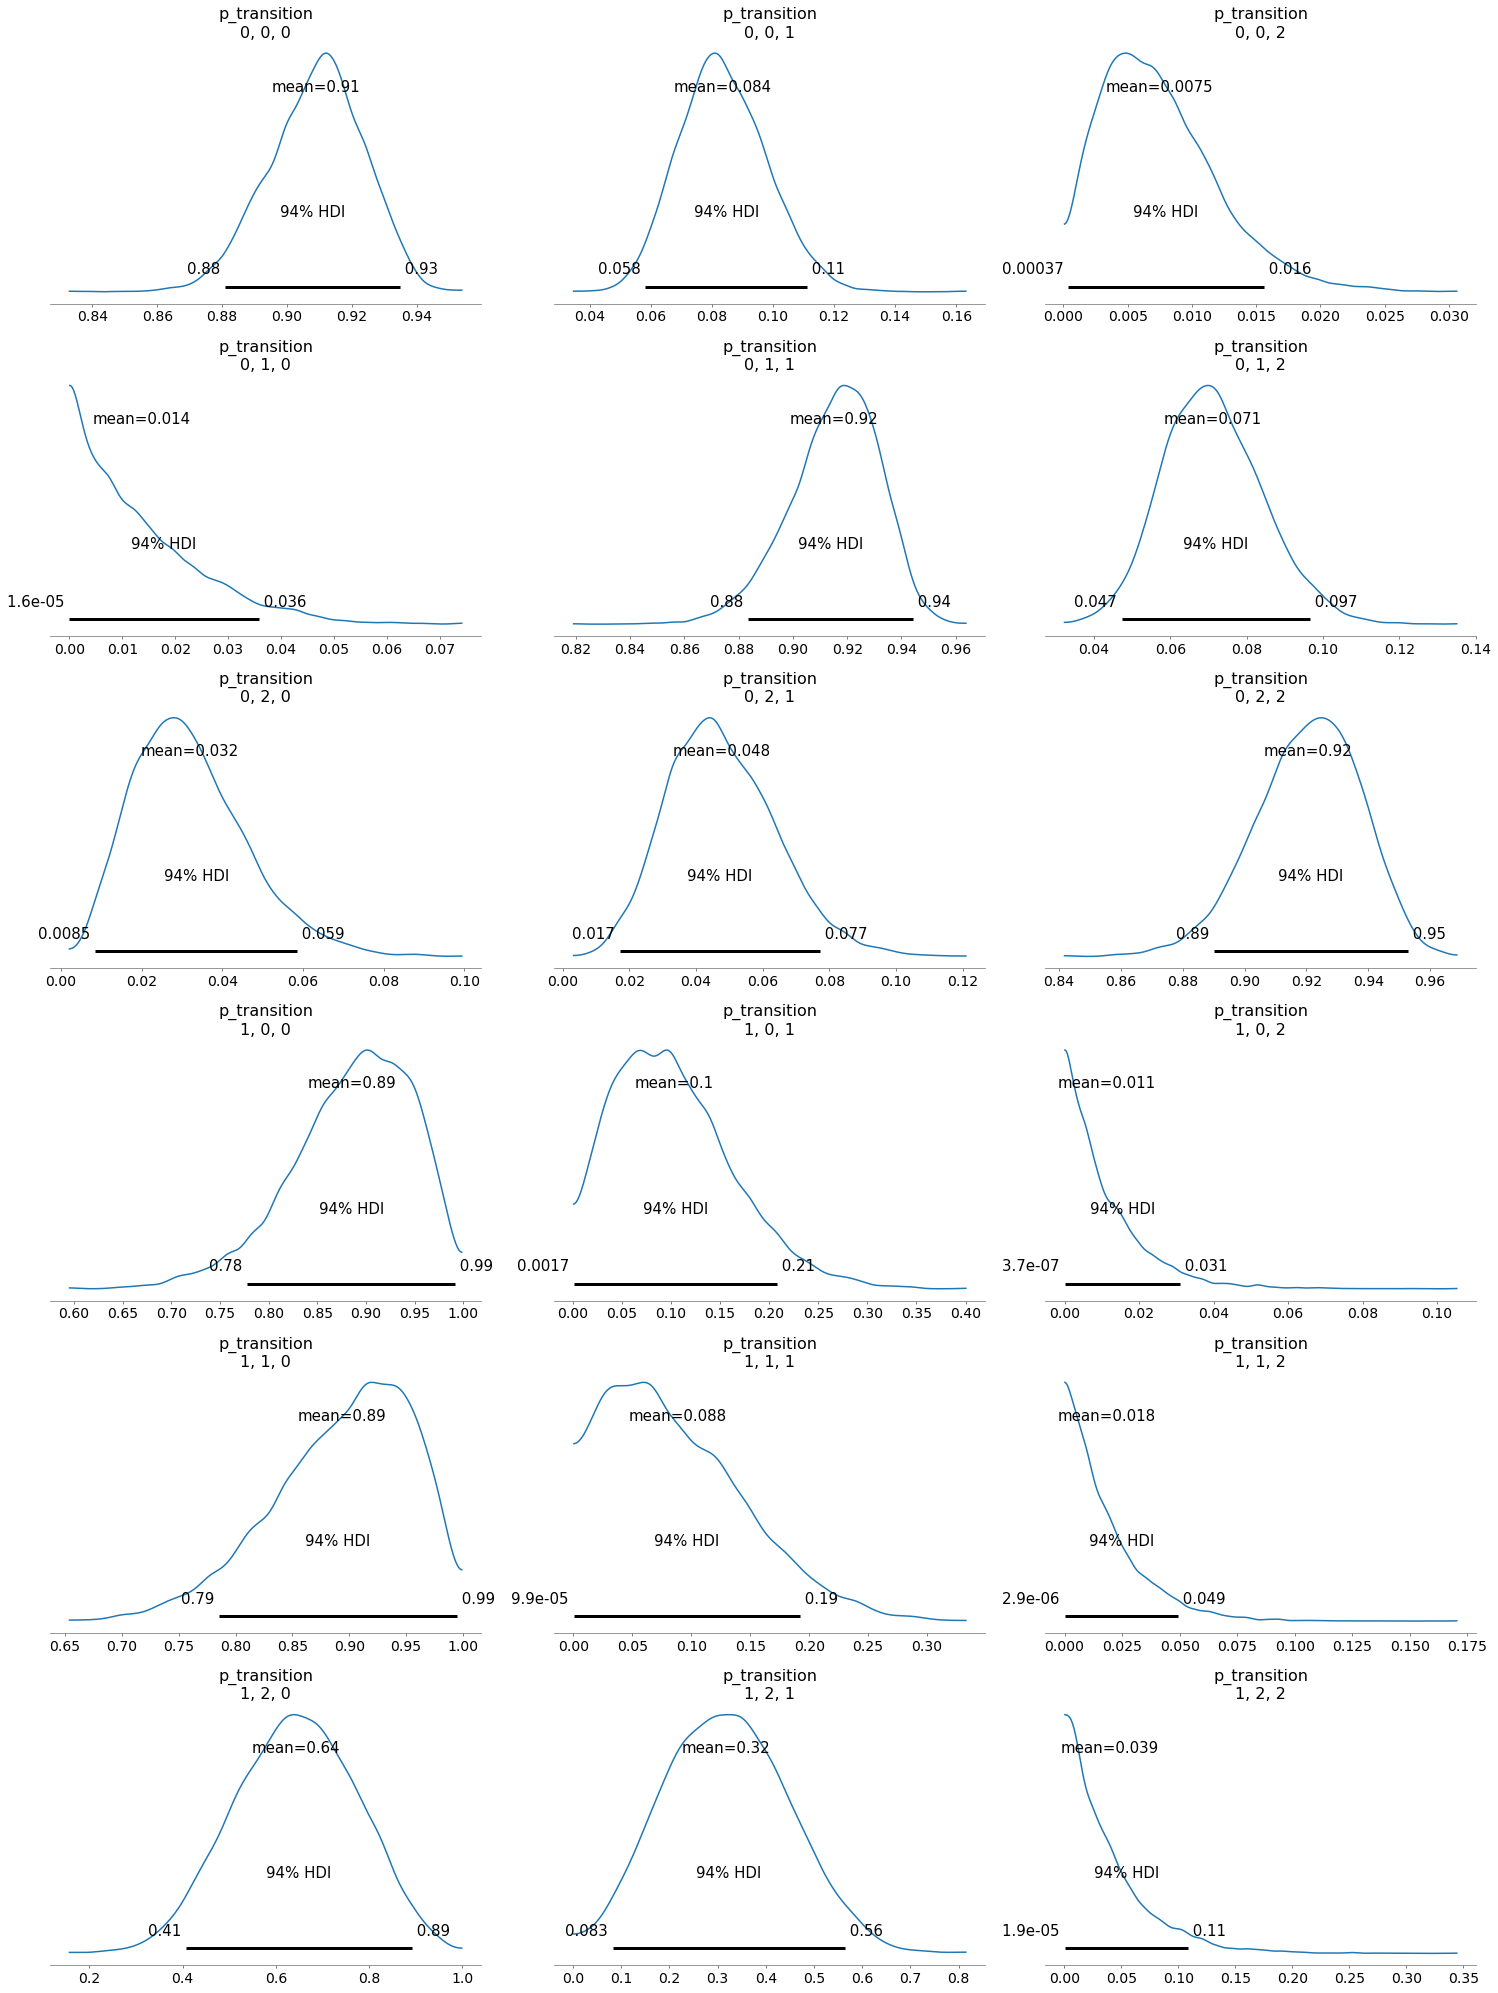

In [33]:
az.plot_posterior(trace,  var_names=["p_transition"]);

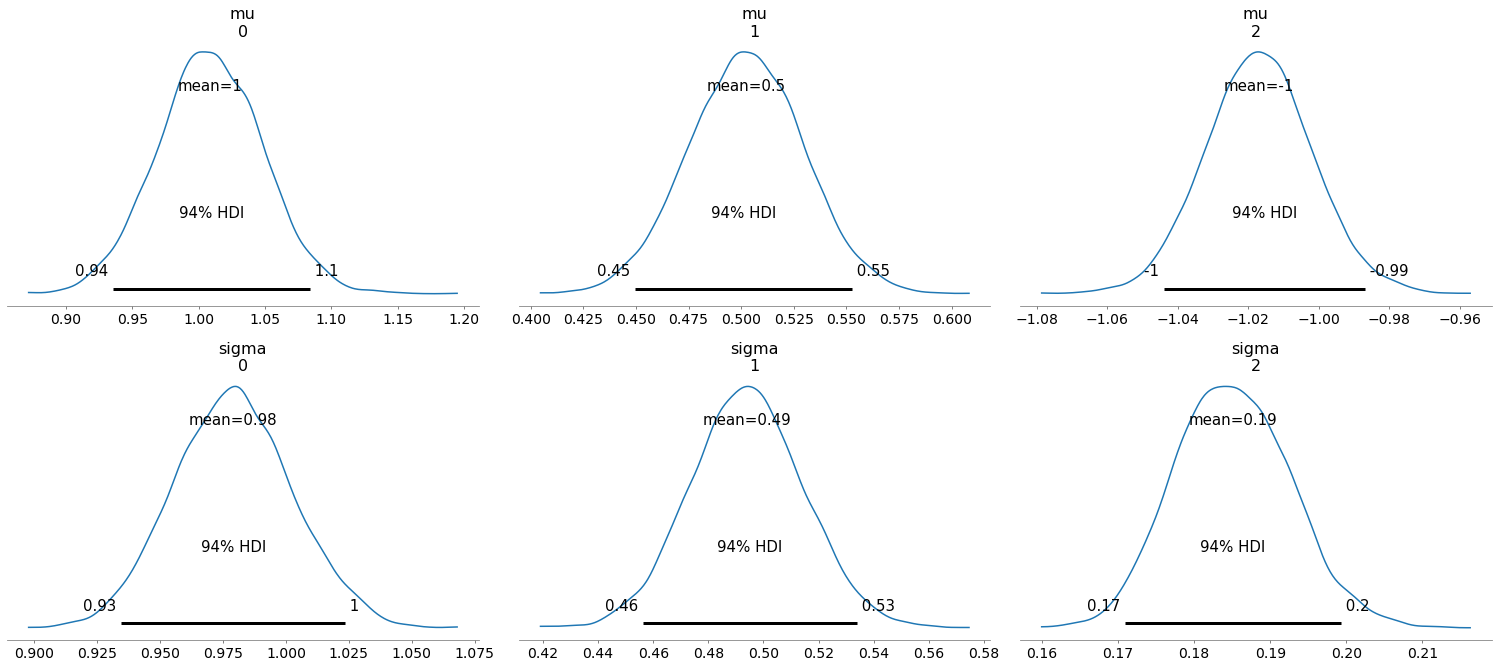

In [34]:
az.plot_posterior(trace,  var_names=["mu", "sigma"]);

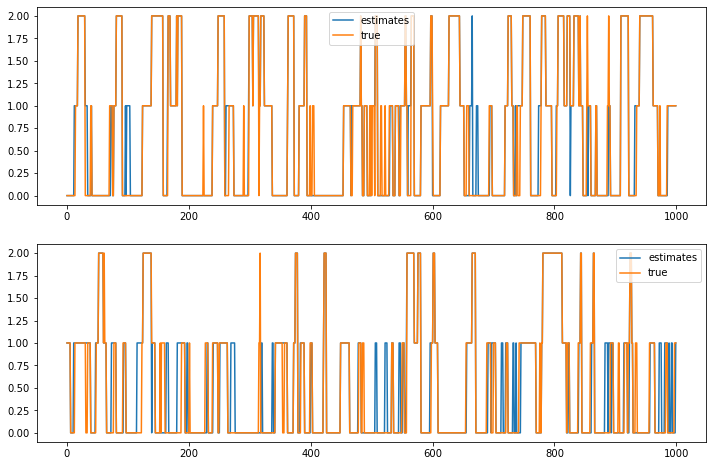

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4*number_seq))
for i in range(number_seq):
    ax[i].plot(np.round(trace["hmm_states_"+str(i)].mean(axis=0)), label="estimates")
    ax[i].plot(np.array(states_all_seq[i, :]), label="true")
    ax[i].legend()

Once again, the HMM successfully estimated the tranisition probability matrices given observations and actions. Also, all other model parameters and hidden states are correctly inferred for the POMDP case with multiple sequences.